In [1]:
import numpy as np
import pandas as pd
from numpy.fft import fft, ifft, fftshift, fftfreq, rfft
import matplotlib.pyplot as plt
from matplotlib import cm
import colorcet as cc

#This are my libraries
import snow.nlo as nlo 
import snow.pulses as pulses
import snow.waveguides as waveguides
import snow.opos as opos
import snow.util as util
import snow.materials as materials

#Larger font for plots
plt.rcParams.update({'font.size': 18})

from scipy.constants import pi, c, epsilon_0, h
hplanck = h
pm = 1e-12
nm = 1e-9
um = 1e-6
mm = 1e-3
ns = 1e-9
ps = 1e-12
fs = 1e-15
MHz = 1e6
GHz = 1e9
THz = 1e12
pJ = 1e-12
fJ = 1e-15
mW = 1e-3
uW = 1e-6
nW = 1e-9

## Time and Frequency domain windows

In [2]:
#Let's set the bandwdith
λ_start = 350*nm
λ_stop = 5*um
f_max = c/λ_start
f_min = c/λ_stop
BW = f_max - f_min

N = 2**11 #I usually pick this one to be a power of 2 but that's not strictly necessary

T = N/BW #Time window size
Δt = 1/BW #Time resolution
t_start = -T/2 #Start of time window
#These are the time and frequency vectors 
t = t_start + np.arange(0, T, step=Δt)
f = fftfreq(N, Δt)
Δf = f[1] - f[0]

f_ref = (f_max + f_min)/2  #This variable will be supplied to several plotting functions
λ_ref = c/f_ref
f_ref = round(f_ref/Δf) * Δf
f_abs = f + f_ref #This is the absolute frequency vector
λ = c/f_abs #This is the wavelength vector

print('Time window size = %0.3f ps' %(T/ps))
print((3*f_max - f_min)/BW) #Try to keep it below 4


λ1 = 1.045*um # SH wavelength
f1 = c/λ1 # SH frequency
f2 = 1/2*f1 # Fundamental frequency
λ2 = c/f2 # Fundamental wavelength

Time window size = 2.571 ps
3.150537634408602


## Waveguide properties

Refractive index at pump = 2.057
Refractive index at signal = 1.854
Poling period for second harmonic generation = 5.1557 um
GVM between 2090.0 nm and 1045.0 nm = 1.3097 fs/mm
GVD at 1045.0 nm = 119.6 fs^2/mm
GVD at 2090.0 nm = 22.3 fs^2/mm


/tmp/ipykernel_3428670/3291764395.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Refractive index at pump = %0.3f' %(n1))
/tmp/ipykernel_3428670/3291764395.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Refractive index at signal = %0.3f' %(n2))
/tmp/ipykernel_3428670/3291764395.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Poling period for second harmonic generation = %0.4f um" %(pp_shg/um))
/tmp/ipykernel_3428670/329176439

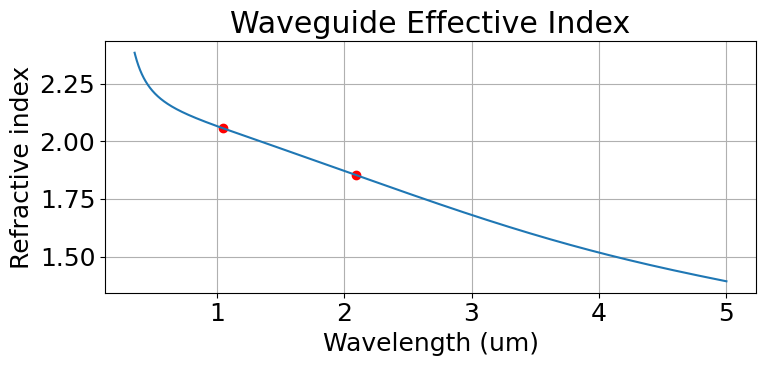

In [3]:
width = 1800*nm
hLN = 700*nm
hetch = 370*nm
wg = waveguides.waveguide(w_top=width, h_thinfilm=hLN, h_etch=hetch, tf_material = 'LN_MgO_e_T',
                         box_material = 'SiO2',  clad_material = 'Air')

T = 25

n = wg.neff(λ, T=T ) #This calculates the refractive index at all wavelengths
n1 = wg.neff( λ1, T=T )
n2 = wg.neff( λ2, T=T )

fig, ax1 = plt.subplots(figsize=(8,4), tight_layout=True)
ax1.plot(fftshift(λ/um), fftshift(n))
ax1.scatter( λ1/um, n1, c='r')
ax1.scatter( λ2/um, n2, c='r')
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.set_title('Waveguide Effective Index')
ax1.grid(True)

print('Refractive index at pump = %0.3f' %(n1))
print('Refractive index at signal = %0.3f' %(n2))

pp_shg = 1/(n1/λ1 - 2*n2/λ2)
print("Poling period for second harmonic generation = %0.4f um" %(pp_shg/um))

gvm_ps = wg.beta1(λ1) - wg.beta1(λ2)
print('GVM between %0.1f nm and %0.1f nm = %0.4f fs/mm' %(λ2/nm, λ1/nm, gvm_ps/(fs/mm)) ) 

gvd_1 = wg.GVD(λ1)
gvd_2 = wg.GVD(λ2)
print('GVD at %0.1f nm = %0.1f fs^2/mm' %(λ1/nm, gvd_1/(fs**2/mm) ) )
print('GVD at %0.1f nm = %0.1f fs^2/mm' %(λ2/nm, gvd_2/(fs**2/mm) ) )

## <span style="color: red;">Parameters to vary</span>

In [4]:
# (1) Length of the poling region can be varied from ~2 mm to ~15 mm
#L_array = np.linspace(2,15,10)*mm
L_array = np.linspace(15,30,15)*mm

# (2) Poling period mismatch can be varied from ~-50 nm to 50 nm
#pp_mismatch_array = np.linspace(-50,50,10)*nm
pp_mismatch_array = np.linspace(-100,10,50)*nm

# (3) Pulse energy parameter can be varied from few fJ to few 1000s of fJ
# We can first start from lower energies
#pump_energy_array = np.linspace(5,1000,10)*fJ
pump_energy_array = np.linspace(1,5000,30)*fJ

## Simulation Loops

finished
Total time = 2.6 s

Input pulse energy = 0.005 pJ
Output pulse energy = 0.005 pJ
finished
Total time = 28.3 s

Input pulse energy = 1.000 pJ
Output pulse energy = 0.996 pJ
finished
Total time = 2.0 s

Input pulse energy = 0.005 pJ
Output pulse energy = 0.005 pJ
finished
Total time = 23.4 s

Input pulse energy = 1.000 pJ
Output pulse energy = 0.996 pJ
finished
Total time = 15.7 s

Input pulse energy = 0.005 pJ
Output pulse energy = 0.005 pJ
finished
Total time = 154.7 s

Input pulse energy = 1.000 pJ
Output pulse energy = 0.968 pJ
finished
Total time = 11.4 s

Input pulse energy = 0.005 pJ
Output pulse energy = 0.005 pJ
finished
Total time = 125.8 s

Input pulse energy = 1.000 pJ
Output pulse energy = 0.969 pJ
Data saved to /home/robert/repo/neuraloperator/examples/SHG_output-trial.csv


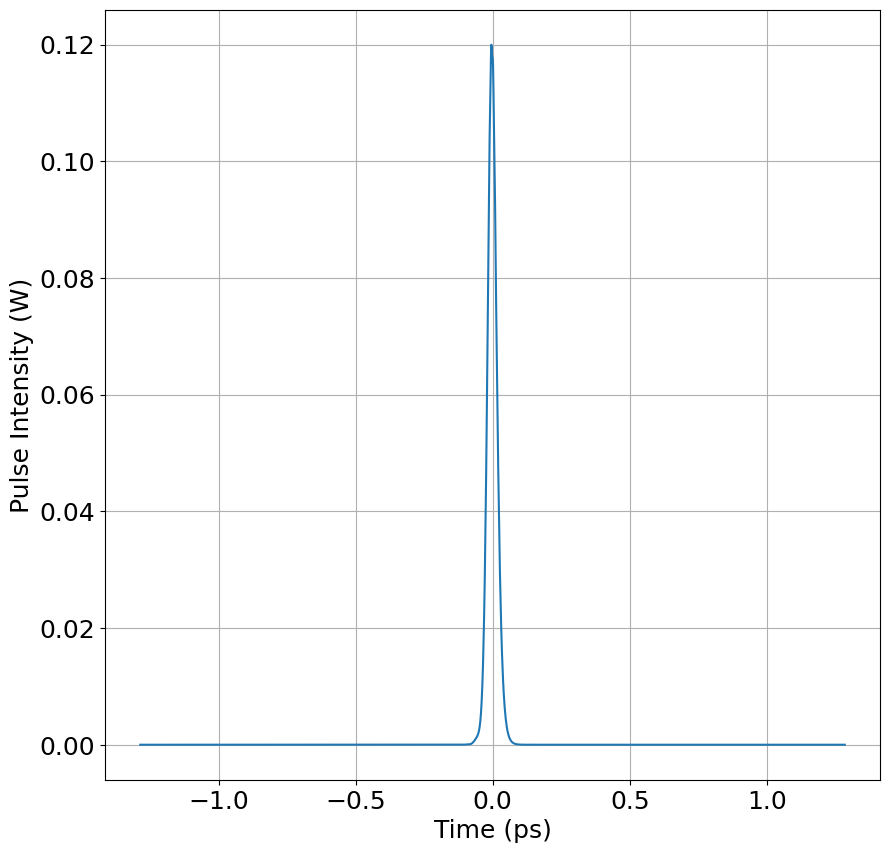

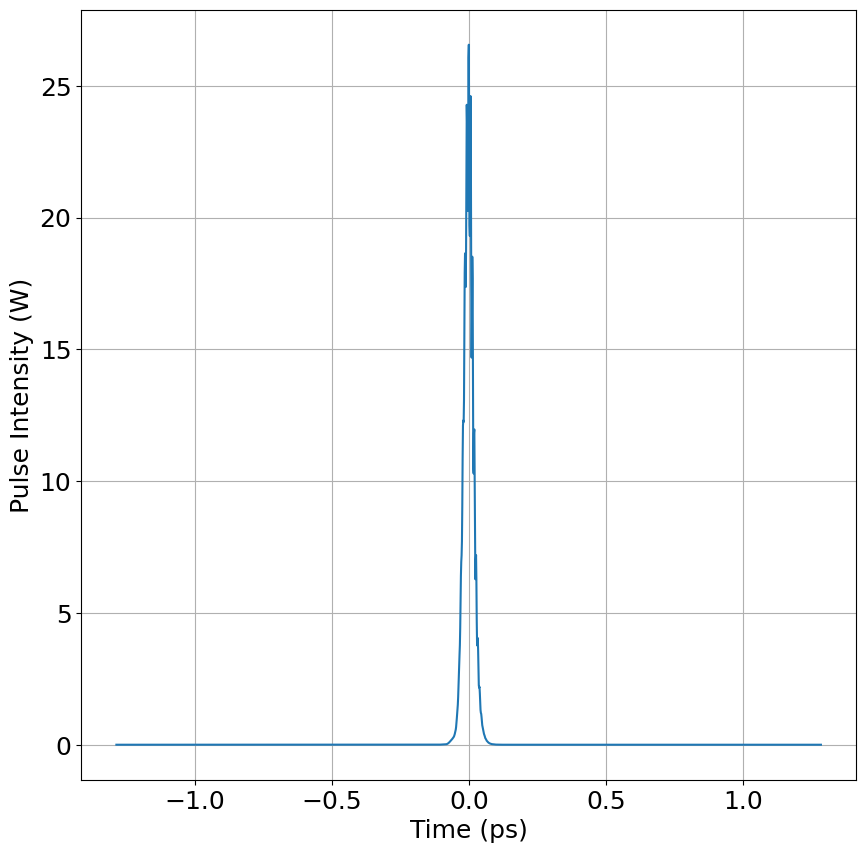

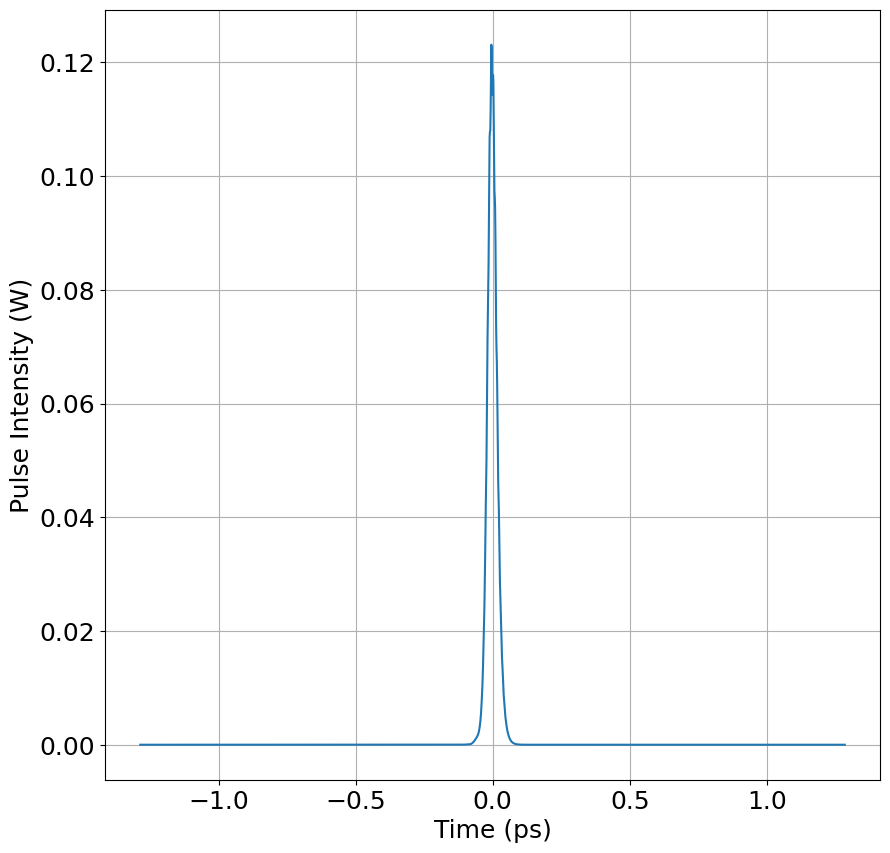

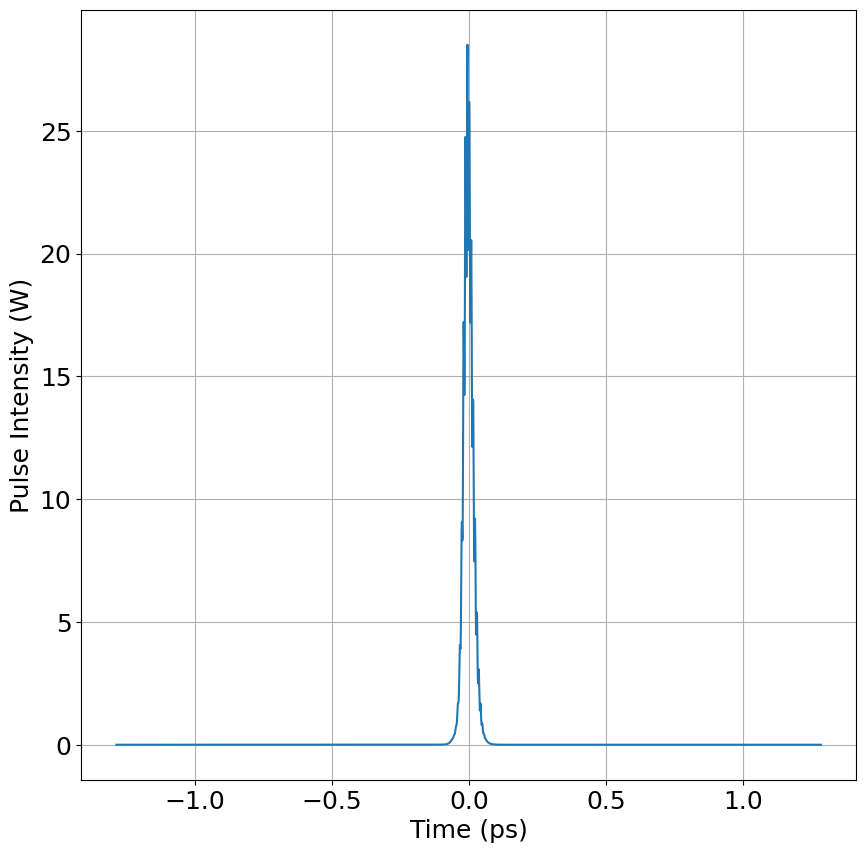

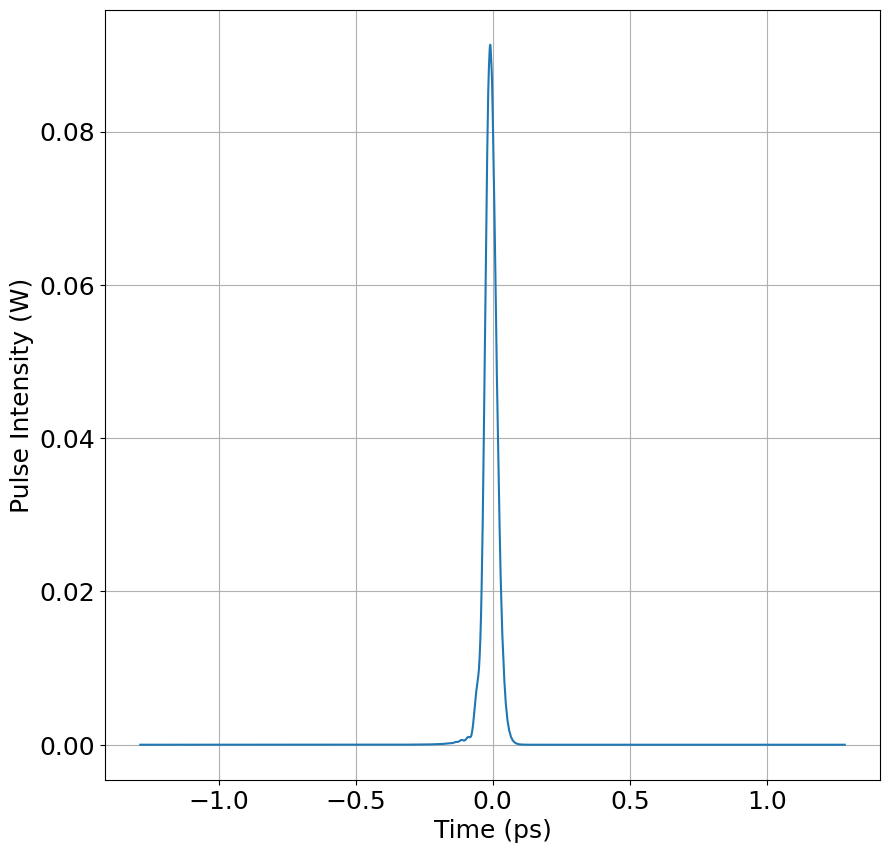

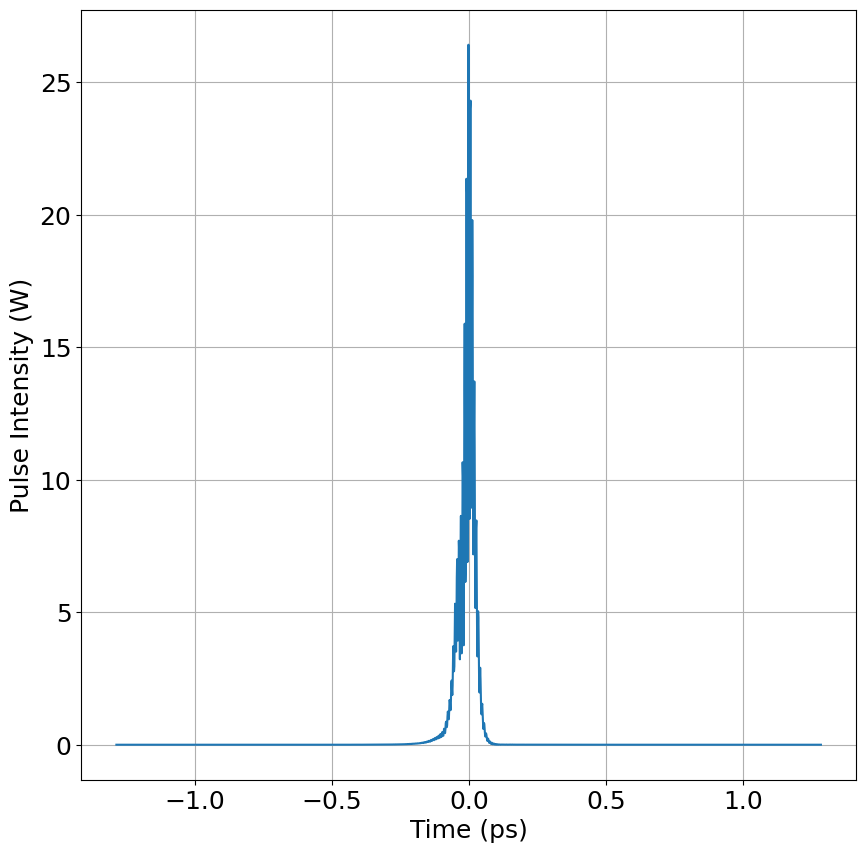

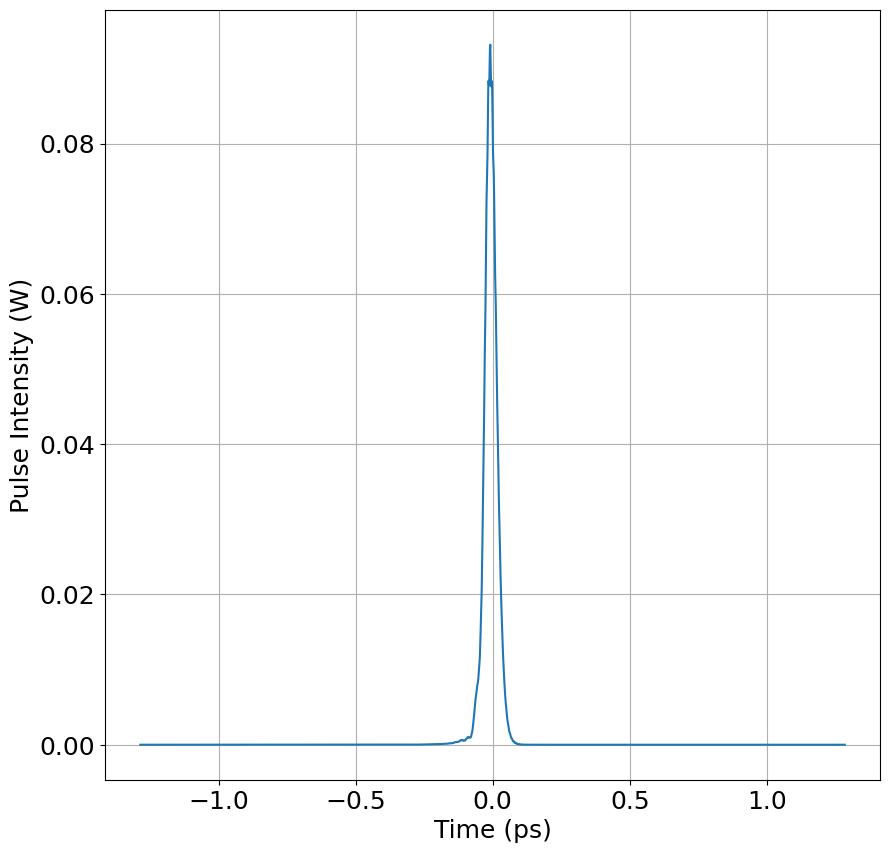

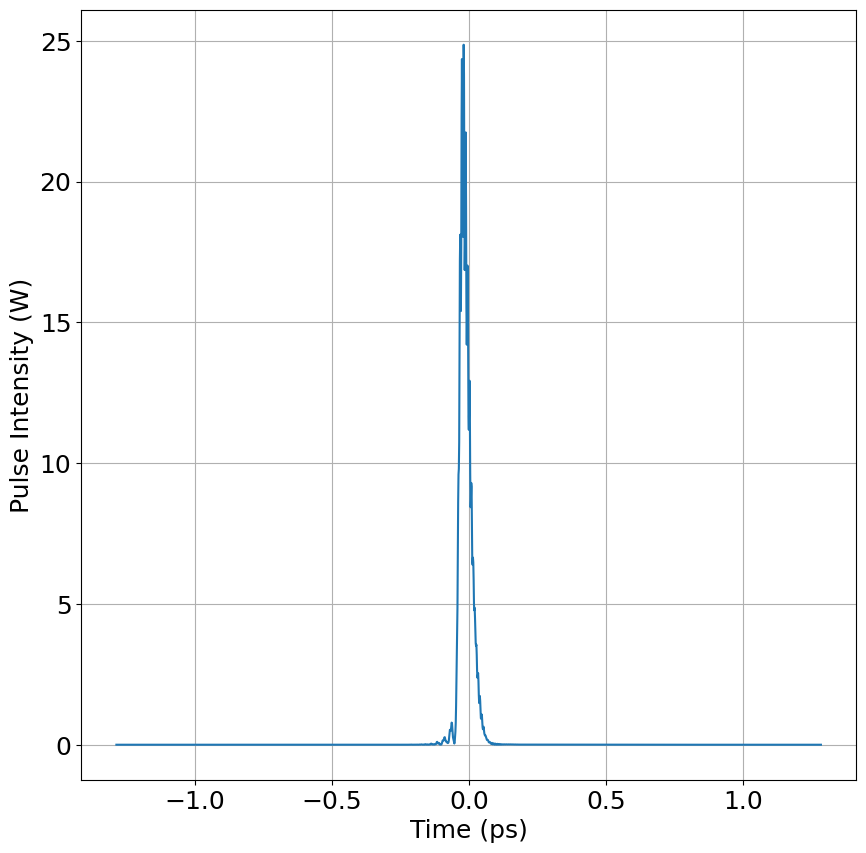

In [5]:
# initialize a list to store all rows of data
data = []
i = 1
for L in L_array:
    for pp_mismatch in pp_mismatch_array:
        for E2 in pump_energy_array:
            # =======================================================================
            # ======== Length, nonlinear coefficients, loss, poling =================
            # =======================================================================

            #L = 5*mm # ******parameter to vary ~2 to 15 mm******
            #pp_mismatch = 0*nm # ******parameter to vary ~ -50 to 50 nm******

            pp = pp_shg  + pp_mismatch

            def poling_func(z):
                return np.sign( np.sin(z*2*pi/pp) )

            Alpha = 0.1 # attentuation coefficient (dB/cm)
            alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

            X0 = 1.1e-12 * 0.75

            wg.add_poling(poling_func)
            wg.set_nonlinear_coeffs(N = 1,  X0=X0)
            wg.set_length(L)
            wg.set_loss(alpha)


            # =======================================================================
            # ========================== Input Pulse ================================
            # =======================================================================
            #E2 = 5*fJ # pump energy ******parameter to vary ~fJ to few pJ******

            τ2 = 35*fs # pump pulse width

            frep = 250*MHz #Repetition rate
            N_dB = 100 #Noise level (relative to the pulse peak)

            a2 = pulses.sech_pulse(t, τ2, Energy=E2, f_ref=f_ref, f0=f2, Npwr_dB=N_dB, frep=frep) # pump pulse

            # check to make sure signal and pump are both well contained in the frequency window

            # pump
            #fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
            #ax1 = a2.plot_magsq(ax=ax1, t_unit='ps')
            #ax2 = a2.plot_spectrum(ax=ax2, f_unit='nm')


            # ===================================================================  ======
            # ====================== Single Pass ======================================
            # =========================================================================
            Tsim = 25
            v_ref = 1/wg.beta1(λ2, T=Tsim)
            a_in = a2

            [a_out, evol_steps] = wg.propagate_NEE(a_in, Kg=0, v_ref=v_ref, zcheck_step = 1*mm, T=Tsim) # ******a_out is output data******

            print('Input pulse energy = %0.3f pJ' %(a_in.energy_td()/pJ))
            print('Output pulse energy = %0.3f pJ' %(a_out.energy_td()/pJ))

            a_out.plot_magsq()
            #a_out.plot_spectrum()

            # =========================================================================
            # ====================== Save Data in .csv ================================
            # =========================================================================
            # Select output data for saving
            
            # wavelength_axis = c/a_out.f_abs/um  # Wavelength axis in micrometer (um)
            # spectral_power_spectrum = a_out.spectrum(a_out.df)  # power spectrum in dBm in wavelength axis
            time_axis = a_out.t/ps  # Time axis in picoseconds (ps)
            output_field = a_out.a  # output pulse
            input_field = a2.a  # input pulse
            
            # updating input parameters
            poling_region_length = L/mm
            poling_period_mismatch = pp_mismatch/nm
            pump_energy = E2/fJ
            
            # combine the values and arrays into a single row
            row = [poling_region_length, poling_period_mismatch, pump_energy] + input_field.tolist() + output_field.tolist()
            
            # append the row to the data list
            data.append(row)
            

            i += 1

            
# Define the column headers

columns = ['Poling Region Length (mm)', 'Poling Period Mismatch (nm)', 'Pump Energy (fJ)'] + [f'Input_{i}' for i in range(N)] + [f'Output_{i}' for i in range(N)]

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=columns)

# Save the DataFrame to a CSV file
csv_file_path = "/home/robert/repo/neuraloperator/examples/SHG_output-trial.csv"
df.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")

In [12]:
def load_and_preprocess_data(file_path, num_samples=5):
    df = pd.read_csv(file_path)
    
    def to_complex(s):
        return complex(s.strip('()').replace('j', 'j').replace(' ', ''))
    
    random_samples = np.random.choice(df.shape[0], num_samples, replace=False)
    features = df[['Poling Region Length (mm)', 'Poling Period Mismatch (nm)', 'Pump Energy (fJ)']].values[:num_samples]
    input_series = df[[f'Input_{i}' for i in range(2048)]].map(to_complex).values[:num_samples]
    output_series = df[[f'Output_{i}' for i in range(2048)]].map(to_complex).values[:num_samples]
    
    input_data = np.zeros((num_samples, 4, 2048), dtype=np.complex128)
    for i in range(3):
        input_data[:, i, :] = np.tile(features[:, i], (2048, 1)).T
    input_data[:, 3, :] = input_series
    
    return input_data, output_series, features


data_path = '/home/robert/repo/neuraloperator/examples/SHG_output-trial.csv'
    
input_data, actual_output, features = load_and_preprocess_data(data_path, num_samples=8)

In [13]:
print(input_data.shape)

(8, 4, 2048)


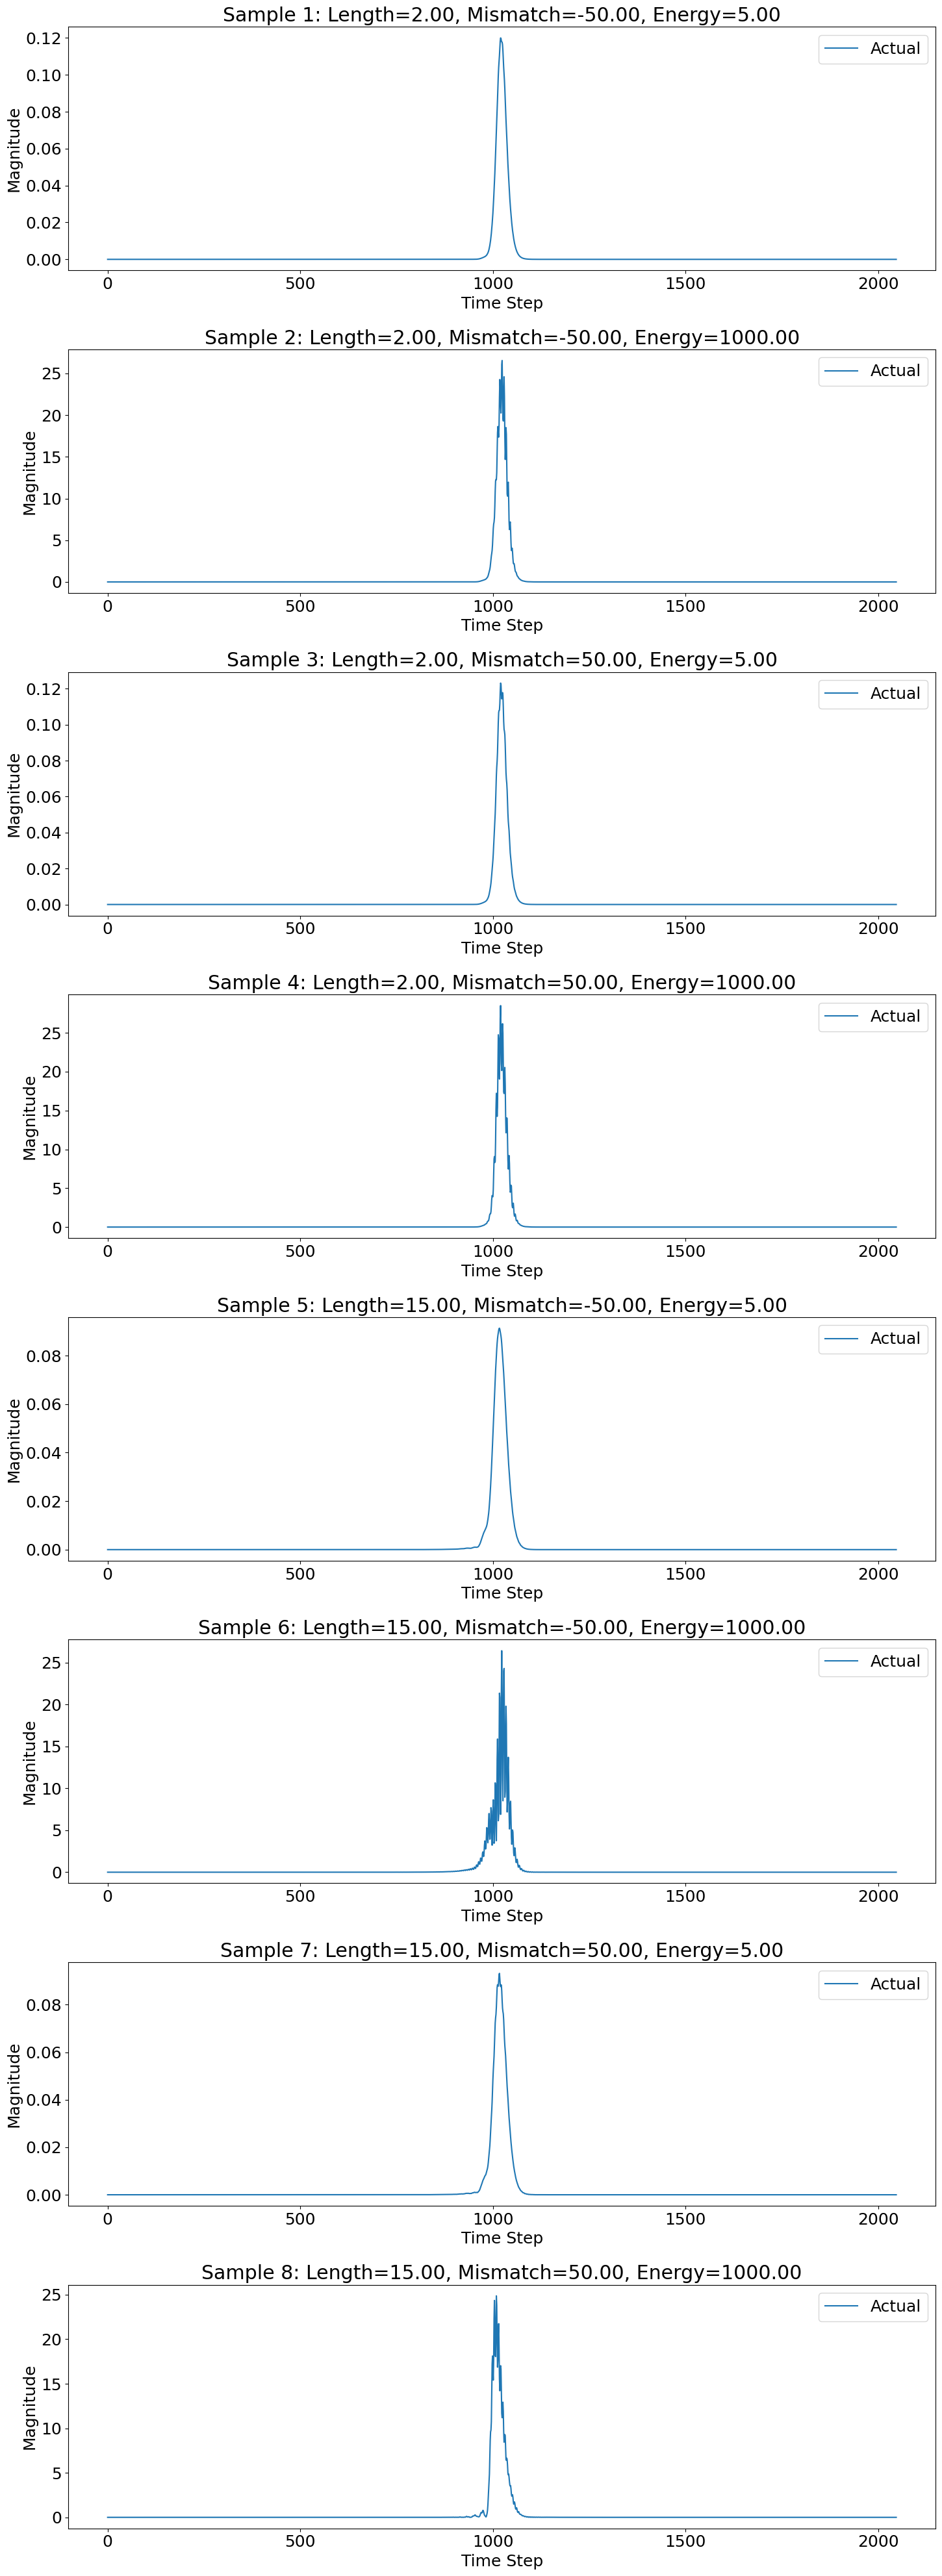

In [14]:
def predict_and_visualize(model=None, input_data=None, actual_output=None, features=None):

    
    num_samples = input_data.shape[0]
    fig, axs = plt.subplots(num_samples, 1, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axs = [axs]
        
    actual_output = np.array(actual_output).reshape(num_samples, 1, 2048)
    
    for i in range(num_samples):
        axs[i].plot(np.abs(actual_output[i, 0, :])**2, label='Actual')
        axs[i].set_title(f"Sample {i+1}: Length={features[i,0]:.2f}, Mismatch={features[i,1]:.2f}, Energy={features[i,2]:.2f}")
        axs[i].set_xlabel('Time Step')
        axs[i].set_ylabel('Magnitude')
        axs[i].legend()
    
    plt.tight_layout()
    plt.savefig('Forward-problem-em.png')
    plt.show()
    
predict_and_visualize(None, input_data, actual_output, features)